# Preprocessing MSS19
Using composite Barcodes
- Detect outlier BCs
- Remove  outlier BCs
- Combine reads for all BCs
- Calcualte activity
- Combine replicates with Mean Centering
- Combine replicates with Zscores

In [5]:
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna 
import pandas as pd
import numpy as np
import itertools
import string
import random
from sklearn.linear_model import LinearRegression
import re
import matplotlib.pyplot as plt
from collections import defaultdict 
import scipy
from scipy import stats
import glob
# import PreprocessingFunctions_LC2AcidBlobs as PF
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import os
import glob
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot

Folder = '20210705/'

if (os.path.isdir('Figures/')):
    print 'Figures folder exists'
else:
    os.mkdir('Figures')
if (os.path.isdir('Figures/'+Folder)):
    print 'Today I will save files in Figures/%s' %Folder
else:
    os.mkdir('Figures/'+Folder)

# DesignedBCs = list(LegacyDF.Barcode)

Figures folder exists
Today I will save files in Figures/20210705/


In [6]:
# Load Support Files 
#Barcode Map
# 'ADseq'=ADBC 'Barcode'==CompoundBarcode and DNAseq 
CompositeBarcodeMapDF = pd.read_pickle('../KeySupportFiles/CompositeBarcodesDF')

# Find the 'no AD' TF control
indx = (CompositeBarcodeMapDF.ADBC=='ATCGATCGA')
CompositeBarcodeMapDF[indx]

,CountsSort1,CountsSort2,CountsSort3,Barcode,ADBC,ADseq
2804,982.0,1030.0,NaN,TTCTTCTGAACCAGGGCTAGCATCGATCGACTCGAG,ATCGATCGA,ATCGATCGA
3713,1193.0,NaN,NaN,TTCTTCTGAACGACCGCTAGCATCGATCGACTCGAG,ATCGATCGA,ATCGATCGA
3808,1.0,26.0,18.0,TTCTTCTGAACGCACGCTAGCATCGATCGACTCGAG,ATCGATCGA,ATCGATCGA
5998,2329.0,NaN,1166.0,TTCTTCTGAATCTCCGCTAGCATCGATCGACTCGAG,ATCGATCGA,ATCGATCGA
9394,261.0,103.0,NaN,TTCTTCTGACATCAAGCTAGCATCGATCGACTCGAG,ATCGATCGA,ATCGATCGA
10055,129.0,NaN,57.0,TTCTTCTGACCAAGCGCTAGCATCGATCGACTCGAG,ATCGATCGA,ATCGATCGA
16529,218.0,NaN,NaN,TTCTTCTGACTACCCGCTAGCATCGATCGACTCGAG,ATCGATCGA,ATCGATCGA
17654,1055.0,22.0,2.0,TTCTTCTGACTGAATGCTAGCATCGATCGACTCGAG,ATCGATCGA,ATCGATCGA
20978,30.0,NaN,NaN,TTCTTCTGAGTCACGGCTAGCATCGATCGACTCGAG,ATCGATCGA,ATCGATCGA
27823,NaN,142.0,1227.0,TTCTTCTGACAAGCCGCTAGCATCGATCGACTCGAG,ATCGATCGA,ATCGATCGA


# Filter on Read Depth, Remove Outliers and merge all BCs
new processing function returns second DF with 3 activity calculations
Developed for MSS18

In [7]:
LegacyDF_original = CompositeBarcodeMapDF
# LegacyDF_original.loc[len(LegacyDF_original.index)] = [0,0,0, 'TTCTTCTGAGCTAGCATCGATCGACTCGAG', 'ATCGATCGA','ATCGATCGA'] 
DesignedBCs = list(CompositeBarcodeMapDF.Barcode)


def processReadCounts_v3(ExpName,data_dir,BinValues,readthreshold,removeOutliers=False):
    filelist = sorted( glob.glob(data_dir+'*.txt'))
    nBCs,columnNames = len(DesignedBCs),[]
    barcodecounts = np.zeros(shape=(nBCs,len(filelist)))
    ExportDF = LegacyDF_original[['ADseq','Barcode']] #changed 20200207 to add the ADseq col
    
    for index, filename in enumerate(filelist):
        myfile = open(filename,'r')
        currentFile = myfile.readlines()
        BCcountsDict = defaultdict(int)
        BCmatchCounter, BCmatchReadCounter, TotalReadCounter = 0,0,0

        print '%s has %i unique sequences' %(filename, len(currentFile))
        for line in currentFile:
            count, seq = line.split()
            count = int(count)
            TotalReadCounter += count
            if len(seq) > 20: #MSS19 use lenient size
                BC = seq#[5:-6] For MSS19 use full sequence as the Barcode
                if BC in DesignedBCs:
                    BCmatchCounter += 1
                    BCmatchReadCounter += count
#                     if count >readthreshold: # 20190304 notice that thershold is taken early. not sure why
                    if count >0:
                        BCcountsDict[BC] += count # only add the BC to the dictionary if it is above the threshold
        fractionReadsMatching = 100.0* BCmatchReadCounter/TotalReadCounter
        print '%i reads with %i matching designed BCs' %(TotalReadCounter,BCmatchReadCounter)
        print '%i BC matches containing %.1f percent of reads' % (BCmatchCounter, fractionReadsMatching)
        # take the count Dictionary and make it into a count matrix with zeros for all the missing data.
        for i, barcode in enumerate(DesignedBCs):
            barcodecounts[i,index] = BCcountsDict[barcode]
        ##########################################
        # add raw counts to the masterDataFrame
        columnName = filename.split('/')[-1].split('.')[0] # first find the filename, then take first part
        columnNames.append(columnName)
        tempBClistDF = ExportDF.Barcode # temp DF for mapping BCs to counts
        tempMap = tempBClistDF.map(BCcountsDict) #much slower (but fast enough)
        ExportDF.loc[:,columnName] = tempMap
    ##########################################################################################    
    # total number of barcoes found accross all samples:
    Number_Designed_BCs_Found = sum(np.sum(barcodecounts,axis=1)>0)
    print '\nIn total, %i designed barcodes were found in this experiment' % Number_Designed_BCs_Found
    # remove barcodes with very few reads
    ThresholdedBCcounts = np.zeros_like(barcodecounts)
    nBCsOverThresh = 0
    for i in xrange(0,nBCs):
        temp = barcodecounts[i,:]
        if sum(temp) > readthreshold: #only counts does no manipulations
            nBCsOverThresh +=1
            ThresholdedBCcounts[i,:] = temp # copies rows that have enough reads
    TotalCountsPerBC = np.sum(ThresholdedBCcounts,axis=1)
    print "There are %r Barcodes with more than %r reads" % (nBCsOverThresh, readthreshold)
    print "There are %r Barcodes with <= %r reads\n" % (Number_Designed_BCs_Found-nBCsOverThresh, readthreshold)
    ##########################################################################################
    # normalize each column by the total number of BC matches in the column i.e. control for sequencing efficiency.
    NormBCcounts1 = np.zeros(shape=(barcodecounts.shape))
    for i in xrange(0,barcodecounts.shape[1]):
        temp = ThresholdedBCcounts[:,i]
        NormBCcounts1[:,i] = temp/sum(temp)
    # normalize each row by total BC matches in the row i.e. calculate relative abundance
    NormBCcounts2 = np.zeros(shape=barcodecounts.shape)
    for i in xrange(0,barcodecounts.shape[0]):
        temp = NormBCcounts1[i,:]
        if sum(temp) > 0:
            NormBCcounts2[i,:]=temp/(sum(temp))
    ##########################################################################################
    ## enter Normalized BCcounts into LegacyDF
    Norm1ColumnNames = [] # make a list of the Norm1 columns names for recomputing 
    for i in xrange(0,NormBCcounts2.shape[1]):
        columnName = columnNames[i]+'_norm1' 
        Norm1ColumnNames.append(columnName)
        ExportDF[columnName]=NormBCcounts1[:,i] # stop saving the first intermediate normalization
        columnName = columnNames[i]+'_norm2'
        ExportDF[columnName]=NormBCcounts2[:,i] # save intermediate for debugging
    ##########################################################################################
    # convert relative abundance across bins into  Expected Fluorescence Value
    Activity = NormBCcounts2.dot(BinValues.transpose())
    ActivityVariance = np.var(NormBCcounts2*BinValues,axis=1)# 20200207 I am starting to doubt this calculation
    ActivitySTD      = np.std(NormBCcounts2*BinValues,axis=1)
    # plot histogram of expression values:
    plothist =0
    if plothist ==1:
        num_bins = 40
        n, bins, patches = plt.hist(Activity[Activity>0], num_bins, normed=0, facecolor='green', alpha=0.5)
        plt.xlabel('Activity')
        plt.ylabel('Counts')
        plt.show()   
    ##########################################################################################
    # enter Activity and ActivityVariance into ExportDF
    ExportDF.loc[:,ExpName+'_Activity'] = Activity
    ExportDF.loc[:,ExpName+'_std'] = ActivitySTD
    ExportDF.loc[:,ExpName+'_SEM'] = ActivitySTD/np.sqrt(TotalCountsPerBC)
    ExportDF.loc[:,ExpName+'_totalReads'] = TotalCountsPerBC
    ##########################################################################################
    # detect outlier BCs
    AvgADActivityAllBCs_Dict = defaultdict(float)
    AvgADActivityOutliersRemoved_Dict = defaultdict(float)
    AvgADActivityOutliersRemovedAndBCsCollapsed_Dict = defaultdict(float)
    BCsperAD_Dict = defaultdict(float)
    BCsperAD_DictOutliersRemoved = defaultdict(float)
    NonOutlierBCs_Dict ={}
    if removeOutliers ==True:
        k =0
        nSigmas = 2
        #For each AD, find all BCs
        for ad in list(set(ExportDF.ADseq)):  
            indx = (ExportDF.ADseq == ad)&(ExportDF[ExpName+'_totalReads']>readthreshold)
            tempDF = ExportDF[indx]
            BCsperAD_Dict[ad] =sum(indx)
            tempActivities = tempDF[ExpName+'_Activity']
            #calculate mean and sigma
            tempMU = np.mean(tempActivities)
            AvgADActivityAllBCs_Dict[ad] = tempMU # store the activity over all BCs for comparisons later
            tempSTD = np.std(tempActivities)
            # find outliers
            mask = np.absolute(tempActivities-tempMU)<(nSigmas*tempSTD)
            BCsperAD_DictOutliersRemoved[ad] = sum(mask)
            # keep track of which BCs are outliers
            tempBCdict = dict(zip(tempDF.Barcode,mask))
            NonOutlierBCs_Dict.update(tempBCdict) # note True means BC is not an outlier; False means BC is an outlier
            # recalculate activity without outlier BCs
            tempActivities_NoOutliers = np.array(tempActivities[mask].values)
            AvgADActivityOutliersRemoved_Dict[ad] = np.mean(tempActivities_NoOutliers)
            
            ## go back to NormBCcounts1 columns and remove the outlier BCs
            tempDF2 = tempDF[mask]
            tempDF3 = tempDF2[Norm1ColumnNames]
            #sum together all the counts
            Norm1BCCountsSum = tempDF3.sum(axis=0)
            
            # recalculate NormBCcounts3 (new version of NormBCCounts2)
            NormBCcounts3=Norm1BCCountsSum/(sum(Norm1BCCountsSum))
            AvgADActivityOutliersRemovedAndBCsCollapsed_Dict[ad] = NormBCcounts3.dot(BinValues.transpose())
            
            debugging=0
            if debugging:
                if k < 4:
                    print Norm1BCCountsSum
                    print NormBCcounts3
                    print NormBCcounts3.dot(BinValues.transpose())
                    k +=1 
                print '%i BCs'%sum(indx)
                print '%i outliers'%(sum(indx)-sum(mask))
    ## add a column to ExportDF that encodes if the BC is an outlier
    ## fixed these lines 20200519 because they were not getting exported properly
    verytempdata = tempBClistDF.map(NonOutlierBCs_Dict)
    ExportDF.loc[:,'NonOutlierBarcodes']= verytempdata
    
    ## combine AD avg data into a second Export DF for ADs only:
    ExportDF_ADs = pd.DataFrame({'ADseq':list(set(ExportDF.ADseq))})
    tempADlist =  ExportDF_ADs.ADseq
    ExportDF_ADs[ExpName+'AvgADActivityAllBCs']= tempADlist.map(AvgADActivityAllBCs_Dict)
    ExportDF_ADs[ExpName+'AvgADActivityOutliersRemoved']= tempADlist.map(AvgADActivityOutliersRemoved_Dict)
    ExportDF_ADs[ExpName+'AvgADActivityOutliersRemovedAndBCsCollapsed']= tempADlist.map(AvgADActivityOutliersRemovedAndBCsCollapsed_Dict)
    ExportDF_ADs[ExpName+'BCsperAD']= tempADlist.map(BCsperAD_Dict)
    ExportDF_ADs[ExpName+'BCsperADOutliersRemoved']= tempADlist.map(BCsperAD_DictOutliersRemoved)
    ##########################################################################################
    # return LegacyDF to jupyter notebook running this script
    print ExportDF.columns
    cols_to_use = ExportDF.columns[2:] #changed 20200207 because I added the ADseq col
    return ExportDF[cols_to_use], ExportDF_ADs
    
    
    

# Nextseq run 20201201

In [8]:
readthreshold = 10
ExpName = 'MSS19_Sort_1' # 
# BinValues = np.array([1,2,3,4]) #
BinValues = np.array([35.19,62.33,89.43,258.74]) #
data_dir = '../../Data/MSS19/nextseq/Sort1/' 
testDF1,testAD_DF1 = processReadCounts_v3(ExpName,data_dir,BinValues,readthreshold,removeOutliers=True)

ExpName = 'MSS19_Sort_2' 
BinValues = np.array([39.92,72.05,109.73,273.49]) 
data_dir = '../../Data/MSS19/nextseq/Sort2/' 
testDF2,testAD_DF2 = processReadCounts_v3(ExpName,data_dir,BinValues,readthreshold,removeOutliers=True)

ExpName = 'MSS19_Sort_3' 
BinValues = np.array([40.64,70.58,109.92,337.19]) 
data_dir = '../../Data/MSS19/nextseq/Sort3/' 
testDF3,testAD_DF3 = processReadCounts_v3(ExpName,data_dir,BinValues,readthreshold,removeOutliers=True)


../../Data/MSS19/nextseq/Sort1/MSS19_01.txtsorted.txt has 270801 unique sequences
8978552 reads with 8615260 matching designed BCs
21158 BC matches containing 96.0 percent of reads
../../Data/MSS19/nextseq/Sort1/MSS19_02.txtsorted.txt has 269145 unique sequences
8235746 reads with 7893114 matching designed BCs
19557 BC matches containing 95.8 percent of reads
../../Data/MSS19/nextseq/Sort1/MSS19_03.txtsorted.txt has 260993 unique sequences
7280811 reads with 6953707 matching designed BCs
19830 BC matches containing 95.5 percent of reads
../../Data/MSS19/nextseq/Sort1/MSS19_04.txtsorted.txt has 282348 unique sequences
8332801 reads with 7928018 matching designed BCs
18027 BC matches containing 95.1 percent of reads

In total, 28496 designed barcodes were found in this experiment
There are 19558 Barcodes with more than 10 reads
There are 8938 Barcodes with <= 10 reads

Index([u'ADseq', u'Barcode', u'MSS19_01', u'MSS19_02', u'MSS19_03',
       u'MSS19_04', u'MSS19_01_norm1', u'MSS19_01_no

In [9]:


ExpName = 'MSS19_Sort_4' 
BinValues = np.array([39.92,72.05,98.89,138.32,235.08,735.45]) 
data_dir = '../../Data/MSS19/nextseq/Sort4/' 
testDF4,testAD_DF4 = processReadCounts_v3(ExpName,data_dir,BinValues,readthreshold,removeOutliers=True)
# testDF4.to_pickle('pickleFiles/MSS19nextseq/%s_%i'%(ExpName,readthreshold))
# tempDF4 = pd.merge(tempDF3, testDF4, left_index=True, right_index=True, how='outer')



../../Data/MSS19/nextseq/Sort4/MSS19_05.txtsorted.txt has 230877 unique sequences
6936031 reads with 6631631 matching designed BCs
17129 BC matches containing 95.6 percent of reads
../../Data/MSS19/nextseq/Sort4/MSS19_06.txtsorted.txt has 197268 unique sequences
5094267 reads with 4860949 matching designed BCs
18836 BC matches containing 95.4 percent of reads
../../Data/MSS19/nextseq/Sort4/MSS19_13.txtsorted.txt has 266007 unique sequences
7948296 reads with 7599187 matching designed BCs
20179 BC matches containing 95.6 percent of reads
../../Data/MSS19/nextseq/Sort4/MSS19_14.txtsorted.txt has 225313 unique sequences
6067808 reads with 5786135 matching designed BCs
19026 BC matches containing 95.4 percent of reads
../../Data/MSS19/nextseq/Sort4/MSS19_15.txtsorted.txt has 227973 unique sequences
6263325 reads with 5957498 matching designed BCs
18173 BC matches containing 95.1 percent of reads
../../Data/MSS19/nextseq/Sort4/MSS19_16.txtsorted.txt has 229261 unique sequences
6712474 reads

# Merge the DataFrames

In [10]:
AD_DF = pd.merge(testAD_DF1, testAD_DF2, left_index=True, right_index=True, how='outer')
AD_DF = pd.merge(AD_DF, testAD_DF3, left_index=True, right_index=True, how='outer')
AD_DF = pd.merge(AD_DF, testAD_DF4, left_index=True, right_index=True, how='outer')
# AD_DF = pd.merge(AD_DF, testAD_DF4N, left_index=True, right_index=True, how='outer')
# AD_DF = pd.merge(AD_DF, testAD_DF5, left_index=True, right_index=True, how='outer')
# AD_DF = pd.merge(AD_DF, testAD_DF5N, left_index=True, right_index=True, how='outer')

In [11]:
AD_DF.to_pickle('pickleFiles/AD_DF_pickle_20210727_10reads')

testAD_DF1.to_pickle('pickleFiles/MSS19_Sort1_RawActivity_10reads')
testAD_DF2.to_pickle('pickleFiles/MSS19_Sort1_RawActivity_10reads')
testAD_DF3.to_pickle('pickleFiles/MSS19_Sort1_RawActivity_10reads')
testAD_DF4.to_pickle('pickleFiles/MSS19_Sort1_RawActivity_10reads')

# AD_DF = pd.read_pickle('pickleFiles/AD_DF_pickle_20210209_100reads')

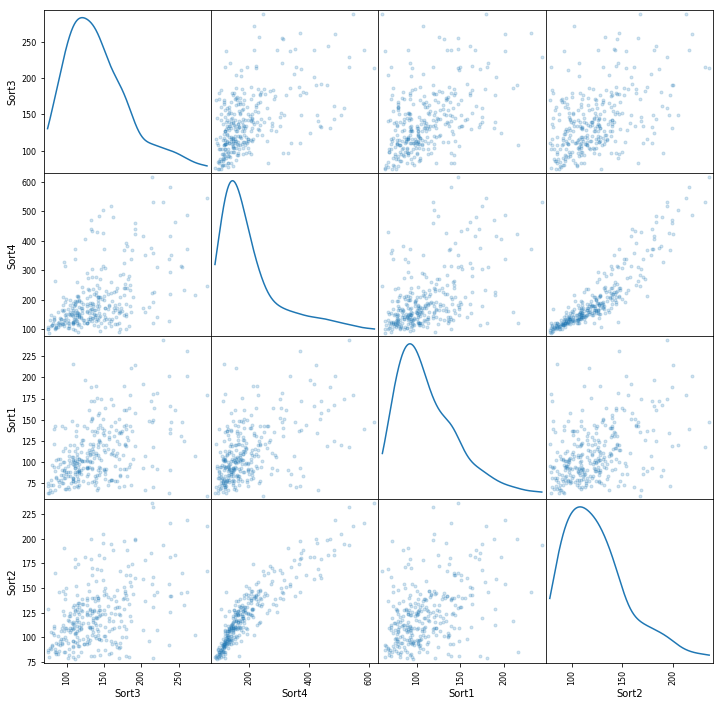

,Sort3,Sort4,Sort1,Sort2
Sort3,1.000000,0.526259,0.448588,0.461195
Sort4,0.526259,1.000000,0.507292,0.908157
Sort1,0.448588,0.507292,1.000000,0.417885
Sort2,0.461195,0.908157,0.417885,1.000000


In [12]:
from pandas.tools.plotting import scatter_matrix
cols = {
#         'MSS19_Sort_1AvgADActivityAllBCs':'Sort1_raw',
#         'MSS19_Sort_2AvgADActivityAllBCs':'Sort2_raw',
#         'MSS19_Sort_3AvgADActivityAllBCs':'Sort3_raw',
        'MSS19_Sort_1AvgADActivityOutliersRemovedAndBCsCollapsed':'Sort1',
        'MSS19_Sort_2AvgADActivityOutliersRemovedAndBCsCollapsed':'Sort2',
        'MSS19_Sort_3AvgADActivityOutliersRemovedAndBCsCollapsed':'Sort3',
    'MSS19_Sort_4AvgADActivityOutliersRemovedAndBCsCollapsed':'Sort4',
}
ExpList =[ 'MSS19_Sort_1AvgADActivityOutliersRemovedAndBCsCollapsed',
        'MSS19_Sort_2AvgADActivityOutliersRemovedAndBCsCollapsed',
        'MSS19_Sort_3AvgADActivityOutliersRemovedAndBCsCollapsed']
# filter on number of BCs
NBCs = 15
indx  =( AD_DF.MSS19_Sort_1BCsperAD >NBCs) |( AD_DF.MSS19_Sort_2BCsperAD >NBCs) |( AD_DF.MSS19_Sort_3BCsperAD >NBCs)

tempDF = AD_DF[indx]
tempDF = tempDF[(cols.keys())]
tempDF = tempDF.rename(columns=cols)
scatter_matrix(tempDF, alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()
tempDF.corr()



In [13]:
# Find the 'no AD' TF control
AD_DF['Barcode']=AD_DF.iloc[:,0]
indx = (AD_DF.Barcode=='ATCGATCGA')
temp = AD_DF[indx]
NoADControlIndex = temp.index[0]
NoADControlIndex

944

In [14]:
indx = (DesignedAD_DF.Barcode=='ATCGATCGA')
DesignedAD_DF[indx][Replicates]

NameError: name 'DesignedAD_DF' is not defined

In [ ]:
DesignedAD_DF[indx][['MSS19_Sort_1BCsperAD','MSS19_Sort_2BCsperAD','MSS19_Sort_3BCsperAD']]

# map AD Barcodes to protein seqs

In [ ]:
## read in designed array
filename = '../../../ArrayDesign/Array4_predictedADs/output/Staller_Array4_20200804v2.txt'
handle = open(filename,'r')
ArraySeqs = handle.readlines()
handle.close()

REsiteDictionary = { 
        'CTTAAG':'AflII','GGATCC':'BamHI',
        'GCTAGC':'NheI','GAGCTC':'SacI',
        'CTCGAG':'XhoI','GAATTC':'EcoRI'}
REsiteDict_Reverse = {v: k for k, v in REsiteDictionary.iteritems()}


UpstreamClusterGREP = 'GCCACCATG'
DownStreamClusterGREP = REsiteDict_Reverse['XhoI']
SeqBeforeAD = 'accatg'.upper()
RESiteBeforeAD =REsiteDict_Reverse['AflII']
# ADlength = VARIABLE
RESiteAfterAD = REsiteDict_Reverse['BamHI']
RESiteBeforeBC  = REsiteDict_Reverse['NheI']
BClength = 9 # for designed BCs. Different length for random. #randBCs are 11 bp
RESiteAfterBC = REsiteDict_Reverse['XhoI']
SeqAtEnd = 'TGTATGCTAT'
firstcodonposition = 16
Insert_Start_Position = 10

InsertLengths = []
DesignedInserts = []
DesignedADs =[] # DNA
DesignedBCs = [] # DNA
DesignedADs_AA =[] #AA
ADBC_2_ADaaseqDict = defaultdict()
for line in ArraySeqs:
    matcher = re.search(UpstreamClusterGREP,line)
    Insert_Start_Position = matcher.start()
    ## USE THE XhoI site after the BC as the end of the insert because GREP on the cluster cuts the sequence off at this position
    seqtouseatend = DownStreamClusterGREP
    matcher = re.search(seqtouseatend,line)
    Insert_End_Position = matcher.start()
    insert = line[Insert_Start_Position:Insert_End_Position+len(seqtouseatend)]
    InsertLengths.append(len(insert))
#     if len(insert) <190:
    DesignedInserts.append(insert) # with the RE sites # updated 201912
    
    ADEnd = re.search(RESiteAfterAD,line)
    adseq_DNA= line[firstcodonposition+3:ADEnd.start()] ##DNA 
    DesignedADs.append(adseq_DNA) # AD seqs
    
    # barcodes
    BeforeBC = re.search(RESiteBeforeBC,line)
    barcode = line[BeforeBC.start()+len(RESiteBeforeAD):Insert_End_Position]
    DesignedBCs.append(barcode) # Barcodes
    
    # translate
    CDS = Seq(adseq_DNA, generic_dna)  #sequence object
    tempAA = str(CDS.translate()) # protein
    DesignedADs_AA.append(tempAA) # AA list
    ADBC_2_ADaaseqDict[barcode]=tempAA
len(DesignedBCs)

tempDF  = AD_DF.loc[:,~AD_DF.columns.duplicated()]
temp = tempDF.ADseq_x
# AD_DF.columns[0]
AD_DF['ADseqProtein'] = temp.map(ADBC_2_ADaaseqDict)
temp = AD_DF.ADseqProtein
DesignedADsindx = temp.notnull()
#add the index for the no AD control TF to this boolean array to carry it into downstream analysis
DesignedADsindx[NoADControlIndex] = True
DesignedAD_DF = AD_DF[DesignedADsindx]
DesignedAD_DF
# added 20210112 to record new column for protein seqs
# DesignedAD_DF.to_pickle('../Preprocessing/pickleFiles/AD_DF_pickle_20210209_100reads_wProteinSeqs')

In [ ]:
violinsets =[]
NoADControl=[]
Replicates = ['MSS19_Sort_1AvgADActivityOutliersRemovedAndBCsCollapsed',
        'MSS19_Sort_2AvgADActivityOutliersRemovedAndBCsCollapsed',
        'MSS19_Sort_3AvgADActivityOutliersRemovedAndBCsCollapsed',
             'MSS19_Sort_4AvgADActivityOutliersRemovedAndBCsCollapsed'
             ]
ListofExperiments = ['Sort1','Sort2','Sort3','Sort4']
for i, activity in enumerate(Replicates):
    tempactivity = DesignedAD_DF[activity]
    tempactivity=tempactivity[tempactivity.notnull()]
    violinsets.append(tempactivity)
    NoADControl.append(tempactivity[NoADControlIndex])
plt.violinplot(violinsets,showmedians=True,)
# plt.scatter(Xs,Ys,c='k') # plot the min and max bin vlues--theoretical maximm dynamic range
plt.scatter([1,2,3,4],NoADControl,c='k')
plt.ylabel('Activity')
plt.xticks([1,2,3,4],ListofExperiments)
plt.savefig('figures/'+Folder+'/ViolinPlot_BioReplicates.pdf')
plt.show()

# Reproducibility

In [ ]:
a, b,c =[],[],[]
xlocations,NumADs =[],[]
Replicates = ['MSS19_Sort_1AvgADActivityOutliersRemovedAndBCsCollapsed',
        'MSS19_Sort_2AvgADActivityOutliersRemovedAndBCsCollapsed',
        'MSS19_Sort_3AvgADActivityOutliersRemovedAndBCsCollapsed']
NBCset =np.linspace(1,50,50)
for NBCs in NBCset:
    # filter on number of BCs
    indx  =DesignedADsindx & (( AD_DF.MSS19_Sort_1BCsperAD >NBCs) |( AD_DF.MSS19_Sort_2BCsperAD >NBCs) |( AD_DF.MSS19_Sort_3BCsperAD >NBCs))
#     indx  =DesignedADsindx & (( AD_DF.MSS19_Sort_1BCsperAD >NBCs) &( AD_DF.MSS19_Sort_2BCsperAD >NBCs) &( AD_DF.MSS19_Sort_3BCsperAD >NBCs))

#     indx  =(( AD_DF.MSS19_Sort_1BCsperAD >NBCs) |( AD_DF.MSS19_Sort_2BCsperAD >NBCs) |( AD_DF.MSS19_Sort_3BCsperAD >NBCs))

    tempDF = AD_DF[indx]
    tempDF = tempDF[(Replicates)]
    tempDF = tempDF.rename(columns=cols)
    tempcorrs = tempDF.corr()
    a.append(tempcorrs.Sort1[1])
    b.append(tempcorrs.Sort1[2])
    c.append(tempcorrs.Sort2[2])
    if (NBCs%10)==0:
        xlocations.append(NBCs)
        NumADs.append(sum(indx))
#     print '\nFor n = %i Barcodes there are %i ADs'% (NBCs, sum(indx))
#     print 'Corrs are %.3f \t %.3f \t %.3f'%(tempcorrs.Sort1[0],tempcorrs.Sort1[2],tempcorrs.Sort2[0])
    
plt.plot(NBCset,a,label = 'Sort1 vs Sort2')
plt.plot(NBCset,b,label = 'Sort1 vs Sort3')
plt.plot(NBCset,c,label = 'Sort2 vs Sort3')
plt.legend(loc=2),plt.title('Designed ADs')
plt.xlabel('Minimum bumber of integration Barcodes in each replicates')
plt.ylabel('Pearson Correlation')
plt.ylim(0,1)
for i,x in enumerate(xlocations):
    plt.text(x,.2,'N = %i'%NumADs[i])
plt.show()

# Merging replicates
### Use the No AD Control TF to adjust the replicates. 
No minimum number of barcodes 
20210705

In [ ]:
newExpList =[]
for activity in ExpList:
    tempActivity = AD_DF[activity]
    tempNoADControl_activity = tempActivity[NoADControlIndex]
    newcolname = activity+'_NormToNoAD'
    newExpList.append(newcolname)
    AD_DF[newcolname] = tempActivity- tempNoADControl_activity+200
    print tempNoADControl_activity
tempDF = AD_DF[newExpList]
AD_DF['Activity_Mean_MSS19'] = tempDF.mean(axis=1)
AD_DF['Activity_STD_MSS19'] = tempDF.std(axis=1)
AD_DF['Activity_SEM_MSS19'] = tempDF.std(axis=1)/ np.sqrt(3)
# import seaborn as sns
# sns.pairplot(data=tempDF)
AD_DF.hist(column='Activity_Mean_MSS19')
plt.show()

AD_DF.shape
AD_DF
# AD_DF.to_pickle('pickleFiles/AD_DF_pickle_20210727_NormByNoADControl')

###  Filter on desinged ADs  and on >10 integration BCs in at least one replicate.
use Z scores to match other Datasets 20210105

In [ ]:
AD_DF_Zscores = pd.DataFrame({'ADseqProtein':AD_DF.ADseqProtein})

NBCs =5
indx  =DesignedADsindx & (( AD_DF.MSS19_Sort_1BCsperAD >NBCs) |( AD_DF.MSS19_Sort_2BCsperAD >NBCs) |( AD_DF.MSS19_Sort_3BCsperAD >NBCs))
Filtered_AD_DF = AD_DF[indx]
print sum(indx)

#only include designed ADs and 
tempcols =[]
for activity in ExpList:
    # for each Biological replicate find the global mean and standard deviation (Sigma)
    colmean = np.mean(Filtered_AD_DF[activity])
    colsigma = np.std(Filtered_AD_DF[activity])
    print '%s \tmean = %.3f \tsigma = %.3f'%(activity,colmean,colsigma)
    # for each measurment, convert the raw activity into a Z score 
# Z score = (raw measurment - mean)/sigma
    tempZs = (Filtered_AD_DF[activity]-colmean)/colsigma
    AD_DF_Zscores[activity+'_Zscore']=tempZs
    tempcols.append(activity+'_Zscore')
tempDF = AD_DF_Zscores[tempcols]
AD_DF['Zscore_Mean_MSS19'] = tempDF.mean(axis=1)
AD_DF['Zscore_SEM_MSS19'] = tempDF.std(axis=1)/ np.sqrt(len(tempcols))

## export the dataframes
# AD_DF_Zscores.to_pickle('pickleFiles/MSS19_AD_DF_Zscores_nextseq20210727_10bcs')
AD_DF.to_pickle('pickleFiles/AD_DF_pickle_20210727_NormByNoADControl')

AD_DF.hist(column='Zscore_Mean_MSS19')
plt.show()
sum(AD_DF.Zscore_Mean_MSS19.notnull())
AD_DF.shape

In [ ]:
AD_DF_Zscores

# How many integrations total? How many integration BCs per ADBC?

In [ ]:
print 'Total Integrations'
print sum(AD_DF.MSS19_Sort_1BCsperAD)
print sum(AD_DF.MSS19_Sort_2BCsperAD)
print sum(AD_DF.MSS19_Sort_3BCsperAD)
print 'Designed AD BC integrations'
print sum(DesignedAD_DF.MSS19_Sort_1BCsperAD)
print sum(DesignedAD_DF.MSS19_Sort_2BCsperAD)
print sum(DesignedAD_DF.MSS19_Sort_3BCsperAD)

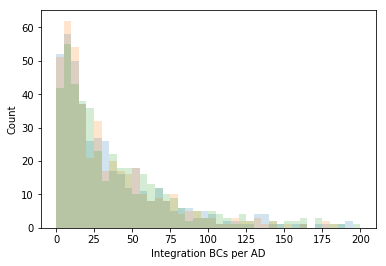

In [24]:
cols = ['MSS19_Sort_1BCsperAD','MSS19_Sort_2BCsperAD','MSS19_Sort_3BCsperAD']
for col in cols:
    plt.hist(DesignedAD_DF[col],np.linspace(0,200,41),alpha=.2)
plt.xlabel('Integration BCs per AD'),plt.ylabel('Count')
plt.savefig('Figures/IntegrationBCsperAD.png')
plt.show()


# look at the data

In [33]:
CandidateADsToTestDF = pd.read_pickle('../../../ArrayDesign/Array4_predictedADs/CandidateADsToTestDF')
AD2Sort1activityDict = dict(zip(AD_DF_Zscores.ADseqProtein,AD_DF_Zscores.Zscore_Mean_MSS19))
temp = CandidateADsToTestDF.ProteinRegionSeq
CandidateADsToTestDF['MSS19_Activity_Zscore'] = temp.map(AD2Sort1activityDict)
AD2Sort1activityDictSEM = dict(zip(AD_DF_Zscores.ADseqProtein,AD_DF_Zscores.Zscore_SEM_MSS19))
CandidateADsToTestDF['MSS19_Activity_Zscore_SEM'] = temp.map(AD2Sort1activityDictSEM)

AD2Sort1activityDict = dict(zip(AD_DF.ADseqProtein,AD_DF.Activity_Mean_MSS19))
CandidateADsToTestDF['MSS19_Activity_Mean'] = temp.map(AD2Sort1activityDict)
AD2Sort1activityDictSEM = dict(zip(AD_DF.ADseqProtein,AD_DF.Activity_SEM_MSS19))
CandidateADsToTestDF['MSS19_Activity_SEM'] = temp.map(AD2Sort1activityDictSEM)
AD2Sort1activityDictSTD = dict(zip(AD_DF.ADseqProtein,AD_DF.Activity_SEM_MSS19))
CandidateADsToTestDF['MSS19_Activity_STD'] = temp.map(AD2Sort1activityDictSTD)
## export the dataframes

# Activities2Add =['MSS19_Activity_Zscore',
#                  'MSS19_Activity_Zscore_SEM',
#                  'MSS19_Sort_1AvgADActivityOutliersRemovedAndBCsCollapsed_Zscore',
#                  'MSS19_Sort_2AvgADActivityOutliersRemovedAndBCsCollapsed_Zscore',
#                  'MSS19_Sort_3AvgADActivityOutliersRemovedAndBCsCollapsed_Zscore']
# print CandidateADsToTestDF.columns
# for activity in Activities2Add:
#     activityDict = dict(zip(AD_DF_Zscores.ADseqProtein,AD_DF_Zscores[activity]))
#     CandidateADsToTestDF[activity] = temp.map(activityDict)
# CandidateADsToTestDF.columns

# export data
CandidateADsToTestDF.to_pickle('pickleFiles/MSS19_DesignedFragments_Zscores_10plusBCs_20210209')
# CandidateADsToTestDF.MSS19_Activity_Mean
# AD_DF.ADseqProtein

0      223.334567
1      188.890781
2      196.047801
3      218.640401
4      159.990755
5      255.847405
6      216.501563
7      199.610578
8      139.860511
9      188.759001
10     207.399021
11     159.310723
12     212.098269
13     199.378789
14     203.008336
15     238.542529
16     260.767706
17     235.175232
18     216.059914
19     256.956498
20     217.110707
21     226.231990
22            NaN
23     229.026671
24     205.310071
25     237.980440
26     213.126944
27     205.819541
28     241.416787
29     182.618401
          ...    
413    195.204673
414    270.798481
415    141.859918
416    249.578491
417    224.155952
418    221.641663
419    206.342506
420    164.701763
421    217.579088
422    197.137930
423           NaN
424    157.211289
425    234.589842
426    221.988718
427    214.860075
428    203.085961
429    234.821019
430    243.668151
431           NaN
432    232.560501
433    243.059417
434    325.172990
435           NaN
436    213.322265
437    211

# Which ADs are missing?

In [26]:
Activity = 'MSS19_Activity_Zscore'
print len(CandidateADsToTestDF[Activity])
missingIndx = (CandidateADsToTestDF[Activity].isnull())
print 'With a threshold of greater than %i BCs, %i ADs are missing, %i are found' % (NBCs,sum(missingIndx),len(CandidateADsToTestDF[Activity])-sum(missingIndx))
CandidateADsToTestDF[missingIndx]

443
With a threshold of greater than 5 BCs, 39 ADs are missing, 404 are found


,End,GeneName,Length,ProteinRegionSeq,RegionType,Start,uniprotIDs,AAseqLengths,MSS19_Activity_Zscore,MSS19_Activity_Zscore_SEM
11,266.0,>sp|Q5TGY3|AHDC1_HUMAN,40.0,EPEPDSTDYSELADADILSELASLTCPEAQLLEAQALEP,Prediction,227.0,NaN,16,NaN,NaN
12,185.0,>sp|A6NFI3|ZN316_HUMAN,58.0,PRDEDLEEEEEEEEDEDEDDLLTAGCQELVTFEDVAVYFSLEEWER...,Prediction,128.0,NaN,16,NaN,NaN
22,470.0,>sp|Q6ZV50|RFX8_HUMAN,57.0,TLCHRDSFGSWHLFHLLLLEYMIHILQSCLEEEEEEEDMGTVKEML...,Prediction,414.0,NaN,16,NaN,NaN
39,289.0,>sp|P78413|IRX4_HUMAN,41.0,KEEKELELSDLDDFDPLEAEPPACELKPPFHSLDGGLERV,Prediction,249.0,NaN,16,NaN,NaN
68,84.0,>sp|Q8N8E2|ZN513_HUMAN,74.0,VKCEGVKVDTEDSLDEGPGALVLESDLLLGQDLEFEEEEEEEEGDG...,Prediction,11.0,NaN,16,NaN,NaN
88,465.0,>sp|O00716|E2F3_HUMAN,58.0,QTEDQIPSNLEGPFVNLLPPLLQEDYLLSLGEEEGISDLFDAYDLE...,Prediction,408.0,NaN,16,NaN,NaN
160,474.0,>sp|Q06945|SOX4_HUMAN,143.0,SPDAPSLSGRSSAASSPAAGRSPADHRGYASLRAASPAPSSAPSHA...,Uniprot,332.0,NaN,16,NaN,NaN
164,529.0,>sp|Q00613|HSF1_HUMAN,136.0,LDNLQTMLSSHGFSVDTSALLDLFSPSVTVPDMSLPDLDSSLASIQ...,Uniprot,394.0,NaN,16,NaN,NaN
248,278.0,>sp|Q9BR84|ZN559_HUMAN,41.0,KFYECKACGKPFTESSYLTQHLRTHSRVLPIEHKKFGKAF,Random,238.0,Q9BR84,16,NaN,NaN
313,273.0,>sp|Q8N1L9|BATF2_HUMAN,56.0,LGSSPDNPSSALGLARLQSREHKPALSAATWQGLVVDPSPHPLLAF...,Random,218.0,Q8N1L9,16,NaN,NaN


In [74]:
# 95th percentile of random is 140 in Sort1
OnOffThresh = 0#.5# (0.653659+0.604300)/2
print 'Using the 95the percentile of Random Regions'
for regiontype in ListofExperiments:
    indx = CandidateADsToTestDF.RegionType==regiontype
    print '%s:\tN = %i'%(regiontype,sum(indx))
    tempDF = CandidateADsToTestDF[indx]
    Nstrong = sum(tempDF[Activity]>OnOffThresh)
    print '%i are other threshold and active'%Nstrong
    print '%.2f percent\n' %(100.0*Nstrong/sum(indx))




Using the 95the percentile of Random Regions
Sort1:	N = 0
0 are other threshold and active


ZeroDivisionError: float division by zero

Controls:	 24
Prediction:	 150
Random:	 150
Uniprot:	 22
GoogleSheet:	 36
ChopCRX:	 26
Choi_ADs:	 35


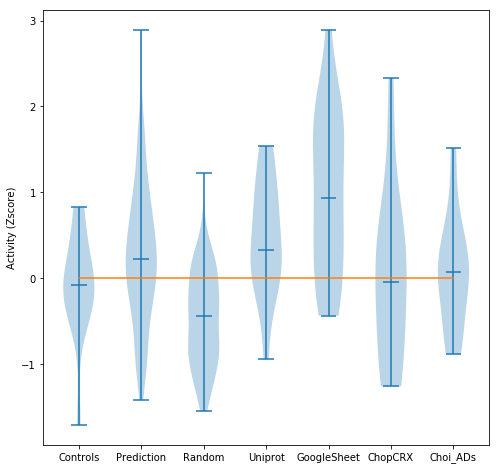

In [75]:
Activity = 'MSS19_Activity_Zscore'
CurrentSEM = 'MSS19_Activity_Zscore_SEM'
violinsets = []
ListofExperiments = [ 'Controls',
 'Prediction',
 'Random',
 'Uniprot', 'GoogleSheet',
 'ChopCRX','Choi_ADs',]
for regiontype in ListofExperiments:
    indx = CandidateADsToTestDF.RegionType==regiontype
    print '%s:\t %i'%(regiontype,sum(indx))
    tempDF = CandidateADsToTestDF[indx]
    tempactiviy = tempDF[Activity]
    tempactiviy=tempactiviy[tempactiviy.notnull()]
    violinsets.append(tempactiviy)

fig,axes  = plt.subplots( figsize=(8,8))

plt.violinplot(violinsets,showmedians=True,)
plt.plot([1,7],[OnOffThresh,OnOffThresh])
# # plt.scatter(Xs,Ys,c='k') # plot the min and max bin vlues--theoretical maximm dynamic range
plt.ylabel('Activity (Zscore)')
plt.xticks([1,2,3,4,5,6,7],ListofExperiments)
plt.savefig('figures/'+Folder+'/ViolinPlot_Experiments_Zscore.pdf')
plt.show()

# ChopCRX

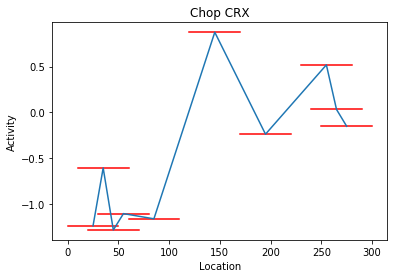

In [18]:
indx = CandidateADsToTestDF.RegionType=='ChopCRX'
tempDF = CandidateADsToTestDF[indx]
xs,ys = [],[]
for i, line in tempDF.iterrows():
    plt.plot([line.Start,line.End],[line[Activity],line[Activity]],c='r')
    if not np.isnan(line[Activity]):
        xs.append(np.mean([line.Start,line.End]))
        ys.append(line[Activity])
plt.plot(xs,ys)
crxPosCtrl = CandidateADsToTestDF[CandidateADsToTestDF.GeneName=='CRXCterm']
xs,ys = [crxPosCtrl['Start'].values,crxPosCtrl['End'].values],[crxPosCtrl[Activity].values,crxPosCtrl[Activity].values]

plt.plot(xs,ys,c='g',)
plt.xlabel('Location'),plt.title('Chop CRX'),plt.ylabel('Activity')
plt.savefig('Figures/'+Folder+'/ChopCRX.png')
plt.show()

## Add smoothing.


In [34]:
def printList(CurrentRegionType='Prediction'):
    indx = CandidateADsToTestDF.RegionType==CurrentRegionType
    tempDF = CandidateADsToTestDF[indx]
    tempDF =tempDF.sort_values(by=Activity,ascending=0) 
    tempDF = tempDF[['GeneName',Activity,'ProteinRegionSeq','Start','End',CurrentSEM]]
    return tempDF
tempDF = printList('Prediction')
tempDF

,GeneName,MSS19_Activity_Zscore,ProteinRegionSeq,Start,End,MSS19_Activity_Zscore_SEM
76,>sp|Q9UIH9|KLF15_HUMAN,3.289686,EHFCLPEFPLGDPDDVPRPFQPTLEEIEEFLEENMEPGV,117.0,156.0,0.695119
87,>sp|Q8WTR7|ZN473_HUMAN,2.101686,LMEDFFEEGFSQEIIEMLSKDGFWNSNFGEACIEDTWLDSLL,84.0,126.0,0.124012
36,>sp|Q96LU7|MRFL_HUMAN,2.023594,GENEALQQFFEAQGANGTLENPALDTSLLEEFLGNDFDLG,4.0,44.0,0.281040
45,>sp|O15353|FOXN1_HUMAN,2.004124,MHDTLLPDGDLGTDLDAINPSLTDFDFQGNLWEQLKDDSLALDPLV,514.0,560.0,0.119350
86,>sp|Q8WTR7|ZN473_HUMAN,1.872930,EEFVTLKDVGMDFTLGDWEQLGLEQGDTFWDTALDNCQDLFLLDPP,2.0,48.0,0.480158
148,>sp|P35638|DDIT3_HUMAN,1.850522,SFGTLSSWELEAWYEDLQEVLSSDENGGTYVSPPGNEEEES,8.0,49.0,0.549591
83,>sp|P41161|ETV5_HUMAN,1.798289,RKFLDTDLAHDSEELFQDLSQLQEAWLAEAQVPDDEQFVPDFQSDN...,31.0,83.0,0.275806
143,>sp|P50549|ETV1_HUMAN,1.765995,RDLAHDSEELFQDLSQLQETWLAEAQVPDNDEQFVPDYQAESLAFHG,36.0,83.0,0.713274
113,>sp|A8MYZ6|FOXO6_HUMAN,1.735739,APDRFPADLDLDMFSGSLECDVESIILNDFMDSDEMDFNFDSALPPPP,428.0,476.0,0.220471
122,>sp|Q8NCP5|ZBT44_HUMAN,1.454669,LNHEASELANYFQSSDFLVPDYLNQEQEETLVQYDLGEHGFESNS,508.0,553.0,0.362550


In [35]:
tempDF = printList('GoogleSheet')
tempDF

,GeneName,MSS19_Activity_Zscore,ProteinRegionSeq,Start,End,MSS19_Activity_Zscore_SEM
327,VP16H2,2.443829,FTPHDSAPYGALDMADFEFEQMFTDALGIDEYGG,457.0,490.0,0.579894
352,c-MybLC1_N,2.298162,PAAAAIQRHYNDEDPEKEKRIKELELLLMSTENELKGQQ,NaN,NaN,0.197032
356,MSG1LC1_N,2.111822,PAIIDSDPVDEEVLMSLVVELGLDRANELPELWLGQNEF,NaN,NaN,0.214401
349,KMT2A/MLL1/CXXC7Zinc,2.107641,SDDGNILPSDIMDFVLKNTPSMQALGESPES,2885.0,2915.0,0.087627
342,ETV5/ETV/PEA3/ERMNterm,2.004076,DLAHDSEELFQDLSQLQEAWLAEAQVPDDEQ,38.0,68.0,1.391660
341,ETV4Nterm,1.542616,GSLPPLDSEDLFQDLSHFQETWLAEAQVPDSDEQFVPDFHSE,43.0,84.0,0.548550
336,p53AD2,1.025280,DDLMLSPDDIEQWFTEDPGPD,41.0,61.0,0.164089
353,c-Mybfull,0.885329,PAAAAIQRHYNDEDPEKEKRIKELELLLMSTENELKGQQVLPTQNH...,NaN,NaN,0.585793
351,NaN,0.807695,DTDELQLEAANETYENNFDNLDFDLDL,40.0,66.0,0.686358
332,STAT4TAD,0.639232,STIRSDSTEPHSPSDLLPMSPSVYAVLRENLSPTTIETAMKSPYSAE,702.0,748.0,0.092379


In [36]:
tempDF = printList('Random')
# tempDF = printList('Uniprot')
tempDF = printList('Controls')
# tempDF = printList('Choi_ADs')
tempDF

,GeneName,MSS19_Activity_Zscore,ProteinRegionSeq,Start,End,MSS19_Activity_Zscore_SEM
429,DWs,0.826829,DWDWDWDWDWDWDWDWDWDWDWDWD,0.0,1.0,0.217653
430,DFs,0.801364,DFDFDFDFDFDFDFDFDFDFDFDFD,0.0,1.0,0.205219
440,p53_AD2_3xA,0.281502,DDLMLSPDDAEQAATEDPGPD,0.0,1.0,0.086336
437,p53_AD1_RS,0.242509,MEEPQSDPSVEPPLSQETFSDRSKLLPENNVLSPLPSQAM,0.0,1.0,0.079661
419,cbl2_Seipel_1992_A,0.138391,LGTPAAASTLCEPTPQDHIKVTQEQYELYCEMGSTFQLCKICAE,0.0,1.0,0.563247
442,p53_AD2_QS,0.127421,DDLMLSPDDIEQQSTEDPGPD,0.0,1.0,0.130783
439,p53_AD1_5xA,0.004472,MEEPQSDPSVEPPLSQETASDAAKAAPENNVLSPLPSQAM,0.0,1.0,0.534552
438,p53_AD1_3xA,0.001425,MEEPQSDPSVEPPLSQETASDAAKLLPENNVLSPLPSQAM,0.0,1.0,0.322582
421,cbl2_Seipel_1992_C,-0.141091,VDPFDPRGSGSLLRQGAEGAPSPNYDDDDDERADDTLFMGSS,0.0,1.0,0.574971
428,Ps,-0.224668,PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP,0.0,1.0,0.414853
